In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.loss import *
from tomopt.volume import *
from tomopt.core import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

# Opt 

In [ ]:
volume = Volume(get_layers())
dets = volume.get_detectors()
opt = torch.optim.SGD(volume.parameters(), lr=2e-3)
mu = MuonBatch(generate_batch(1000), init_z=1)
volume(mu)
scatters = ScatterBatch(mu, volume)
inferer = X0Inferer(scatters)
pred, weight = inferer.pred_x0()
loss_func = DetectorLoss(1)
loss_val = loss_func(pred, weight, inferer.volume)

In [27]:
torch.optim.SGD(volume.parameters(), lr=2e-8)
opt.zero_grad()
dets = volume.get_detectors()

In [28]:
loss_val.backward()

In [9]:
for i in range(4):
    print(i, dets[i].resolution.grad, dets[i].efficiency.grad) 

0 tensor([[ 0.2019,  0.1988,  0.1985, -0.0337,  0.1049,  0.1825, -0.6029, -0.0251,
          0.1410,  0.1994],
        [ 0.1155,  0.1602,  0.1748,  0.1771,  0.0589,  0.2000,  0.1445,  0.0751,
          0.1185,  0.2002],
        [ 0.1633,  0.1977,  0.1818,  0.1638, -0.0565,  0.1123,  0.0510, -0.4711,
          0.1693,  0.0806],
        [ 0.1063,  0.1937,  0.1217,  0.1826,  0.1275,  0.1106,  0.0811,  0.1403,
         -0.1640, -0.2790],
        [ 0.1512,  0.0389,  0.1092, -0.0461,  0.1623,  0.1375,  0.0775,  0.1675,
         -0.1400,  0.1042],
        [ 0.1934,  0.1859,  0.0562,  0.1102, -0.3446, -0.2543,  0.0415, -0.0685,
         -0.0184,  0.1983],
        [ 0.1401, -0.1586,  0.1933, -0.1749,  0.1918,  0.1798,  0.0850,  0.1941,
          0.1485,  0.1786],
        [ 0.1624,  0.1592,  0.1857,  0.1820,  0.0228,  0.0706, -0.0333, -0.0052,
         -0.0445,  0.1931],
        [ 0.1949,  0.1484,  0.1621, -0.0413,  0.1539,  0.1953,  0.1961,  0.1793,
         -0.0096,  0.1969],
        [ 0.1974,

In [10]:
for l in volume.get_detectors():  torch.nan_to_num_(l.resolution.grad, 0)

In [11]:
for i in range(4):
    print(i, dets[i].resolution.grad, dets[i].efficiency.grad) 

0 tensor([[ 0.2019,  0.1988,  0.1985, -0.0337,  0.1049,  0.1825, -0.6029, -0.0251,
          0.1410,  0.1994],
        [ 0.1155,  0.1602,  0.1748,  0.1771,  0.0589,  0.2000,  0.1445,  0.0751,
          0.1185,  0.2002],
        [ 0.1633,  0.1977,  0.1818,  0.1638, -0.0565,  0.1123,  0.0510, -0.4711,
          0.1693,  0.0806],
        [ 0.1063,  0.1937,  0.1217,  0.1826,  0.1275,  0.1106,  0.0811,  0.1403,
         -0.1640, -0.2790],
        [ 0.1512,  0.0389,  0.1092, -0.0461,  0.1623,  0.1375,  0.0775,  0.1675,
         -0.1400,  0.1042],
        [ 0.1934,  0.1859,  0.0562,  0.1102, -0.3446, -0.2543,  0.0415, -0.0685,
         -0.0184,  0.1983],
        [ 0.1401, -0.1586,  0.1933, -0.1749,  0.1918,  0.1798,  0.0850,  0.1941,
          0.1485,  0.1786],
        [ 0.1624,  0.1592,  0.1857,  0.1820,  0.0228,  0.0706, -0.0333, -0.0052,
         -0.0445,  0.1931],
        [ 0.1949,  0.1484,  0.1621, -0.0413,  0.1539,  0.1953,  0.1961,  0.1793,
         -0.0096,  0.1969],
        [ 0.1974,

In [12]:
opt.step()

In [14]:
for i in range(4):
    print(i, dets[i].resolution.sum(), dets[i].efficiency.sum()) 

0 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)
1 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)
2 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)
3 tensor(99999.9844, grad_fn=<SumBackward0>) tensor(24.0042, grad_fn=<SumBackward0>)


In [9]:
volume = Volume(get_layers())
opt = torch.optim.SGD([{'params':(l.resolution for l in volume.get_detectors()), 'lr':2e1},
                       {'params':(l.efficiency for l in volume.get_detectors()), 'lr':2e-5}])
loss_func = DetectorLoss(0.15)
loss_hist = []
for i in range(10):
    mu = MuonBatch(generate_batch(100), init_z=1)
    volume(mu)
    scatters = ScatterBatch(mu, volume)
    inferer = X0Inferer(scatters)
    pred, weight = inferer.pred_x0()
    loss_val = loss_func(pred, weight, inferer.volume)
    loss_hist.append(loss_val.data.item())
    print(i, loss_hist[-1])
    opt.zero_grad()
    loss_val.backward()
    for l in volume.get_detectors():
        torch.nan_to_num_(l.resolution.grad, 0)
        torch.nan_to_num_(l.efficiency.grad, 0)
    opt.step()
    for j,l in enumerate(volume.get_detectors()):
        print(j, l.resolution.mean(), l.efficiency.mean()) 

0 6888.462890625
0 tensor(999.5652, grad_fn=<MeanBackward0>) tensor(0.4997, grad_fn=<MeanBackward0>)
1 tensor(999.6255, grad_fn=<MeanBackward0>) tensor(0.4997, grad_fn=<MeanBackward0>)
2 tensor(999.8046, grad_fn=<MeanBackward0>) tensor(0.4997, grad_fn=<MeanBackward0>)
3 tensor(999.5739, grad_fn=<MeanBackward0>) tensor(0.4997, grad_fn=<MeanBackward0>)
1 6743.17333984375
0 tensor(999.1434, grad_fn=<MeanBackward0>) tensor(0.4994, grad_fn=<MeanBackward0>)
1 tensor(999.1632, grad_fn=<MeanBackward0>) tensor(0.4994, grad_fn=<MeanBackward0>)
2 tensor(999.3439, grad_fn=<MeanBackward0>) tensor(0.4994, grad_fn=<MeanBackward0>)
3 tensor(999.1872, grad_fn=<MeanBackward0>) tensor(0.4994, grad_fn=<MeanBackward0>)
2 7593.03271484375
0 tensor(999.1211, grad_fn=<MeanBackward0>) tensor(0.4988, grad_fn=<MeanBackward0>)
1 tensor(999.2184, grad_fn=<MeanBackward0>) tensor(0.4988, grad_fn=<MeanBackward0>)
2 tensor(999.2045, grad_fn=<MeanBackward0>) tensor(0.4988, grad_fn=<MeanBackward0>)
3 tensor(998.8605, gr

In [10]:
dets = volume.get_detectors()

In [11]:
for i in range(4):
    print(i, dets[i].resolution)

0 Parameter containing:
tensor([[ 994.5491, 1000.0120,  994.3378,  994.3382,  996.9055,  997.8247,
          994.8431,  994.4858,  995.2695,  994.7416],
        [ 996.8724, 1014.6913,  994.1092,  994.4806,  996.2865,  994.9346,
          994.6623,  994.9897,  996.8088,  994.3865],
        [ 994.5817,  995.3156,  995.4564,  994.8702,  995.3342,  995.1680,
          996.0333,  997.3544,  994.5963,  994.0673],
        [ 995.1641,  995.2540,  999.5945,  997.2639,  997.5950,  997.3376,
          995.2704,  997.0224,  994.4436,  994.1663],
        [ 994.0583,  993.7242,  994.9742,  994.1768,  998.6234,  994.9465,
          995.2460,  999.6749,  996.4465,  994.4942],
        [ 994.5347,  994.8700,  994.3140,  994.9363,  995.0374,  994.4845,
          994.6865,  994.7275,  996.3755, 1031.2869],
        [ 994.0085,  995.9317,  996.0974,  994.4684,  996.7349, 1000.3521,
         1040.0397, 1002.2151,  994.4133,  994.4385],
        [ 994.7951,  999.5226,  996.8412,  996.5202, 1004.1487,  997.6205

In [12]:
for i in range(4):
    print(i, dets[i].efficiency) 

0 Parameter containing:
tensor([[0.4992, 0.4949, 0.4989, 0.4993, 0.4973, 0.4915, 0.4992, 0.4990, 0.4987,
         0.4984],
        [0.4969, 0.4859, 0.4994, 0.4993, 0.4982, 0.4989, 0.4988, 0.4983, 0.4969,
         0.4988],
        [0.4992, 0.4983, 0.4984, 0.4985, 0.4987, 0.4972, 0.4973, 0.4968, 0.4991,
         0.4994],
        [0.4968, 0.4984, 0.4955, 0.4970, 0.4955, 0.4965, 0.4985, 0.4957, 0.4985,
         0.4993],
        [0.4995, 0.4989, 0.4988, 0.4990, 0.4938, 0.4967, 0.4977, 0.4935, 0.4974,
         0.4990],
        [0.4993, 0.4978, 0.4993, 0.4985, 0.4968, 0.4974, 0.4989, 0.4991, 0.4948,
         0.4548],
        [0.4994, 0.4972, 0.4976, 0.4993, 0.4962, 0.4831, 0.4594, 0.4934, 0.4906,
         0.4994],
        [0.4987, 0.4949, 0.4963, 0.4971, 0.4920, 0.4936, 0.4839, 0.4958, 0.4992,
         0.4992],
        [0.4988, 0.4986, 0.4958, 0.4932, 0.4991, 0.4990, 0.4943, 0.4978, 0.4986,
         0.4994],
        [0.4994, 0.4983, 0.4996, 0.4975, 0.4959, 0.4893, 0.4991, 0.4996, 0.4938,
    

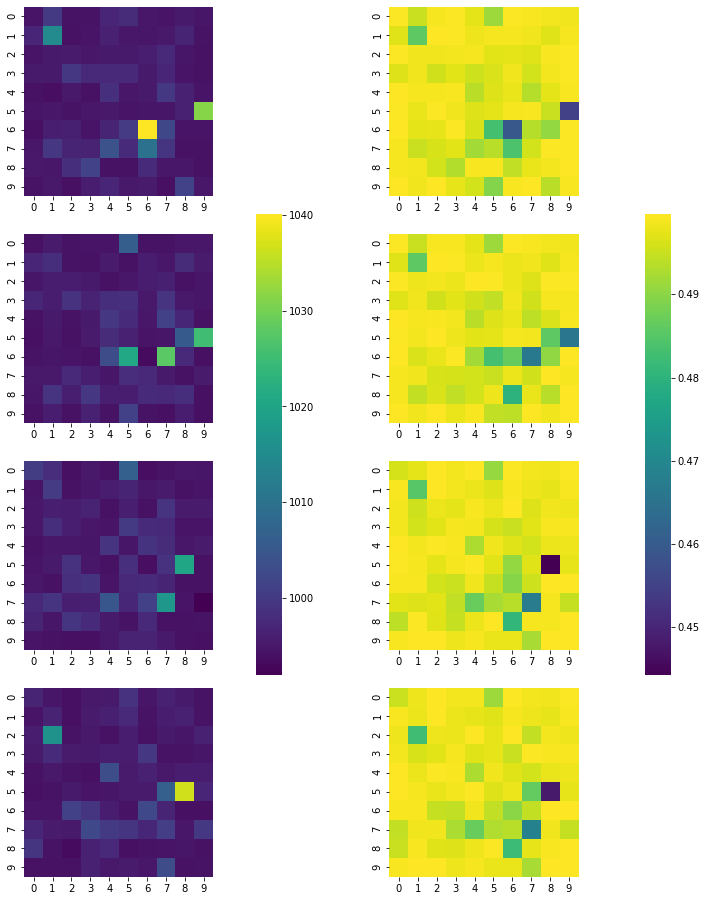

In [31]:
fig,axs = plt.subplots(4,2, figsize=(12,16))
res_cbar_ax = fig.add_axes([.46, .3, .03, .4])
eff_cbar_ax = fig.add_axes([.91, .3, .03, .4])
res = np.array([l.resolution.data.cpu().numpy() for l in volume.get_detectors()])
eff = np.array([l.efficiency.data.cpu().numpy() for l in volume.get_detectors()])
res_min,res_max = res.min(),res.max()
eff_min,eff_max = eff.min(),eff.max()

for i,l in enumerate(volume.get_detectors()):
    sns.heatmap(res[i], ax=axs[i][0], cmap='viridis', square=True, cbar=(i == 0), vmin=res_min, vmax=res_max, cbar_ax=None if i != 0 else res_cbar_ax)
    sns.heatmap(eff[i], ax=axs[i][1], cmap='viridis', square=True, cbar=(i == 0), vmin=eff_min, vmax=eff_max, cbar_ax=None if i != 0 else eff_cbar_ax)    

In [58]:
mu = MuonBatch(generate_batch(10000), init_z=1)
volume(mu)
sb = ScatterBatch(mu, volume)

In [67]:
inferer = X0Inferer(sb, default_pred=None)
pred, weight = inferer.pred_x0()

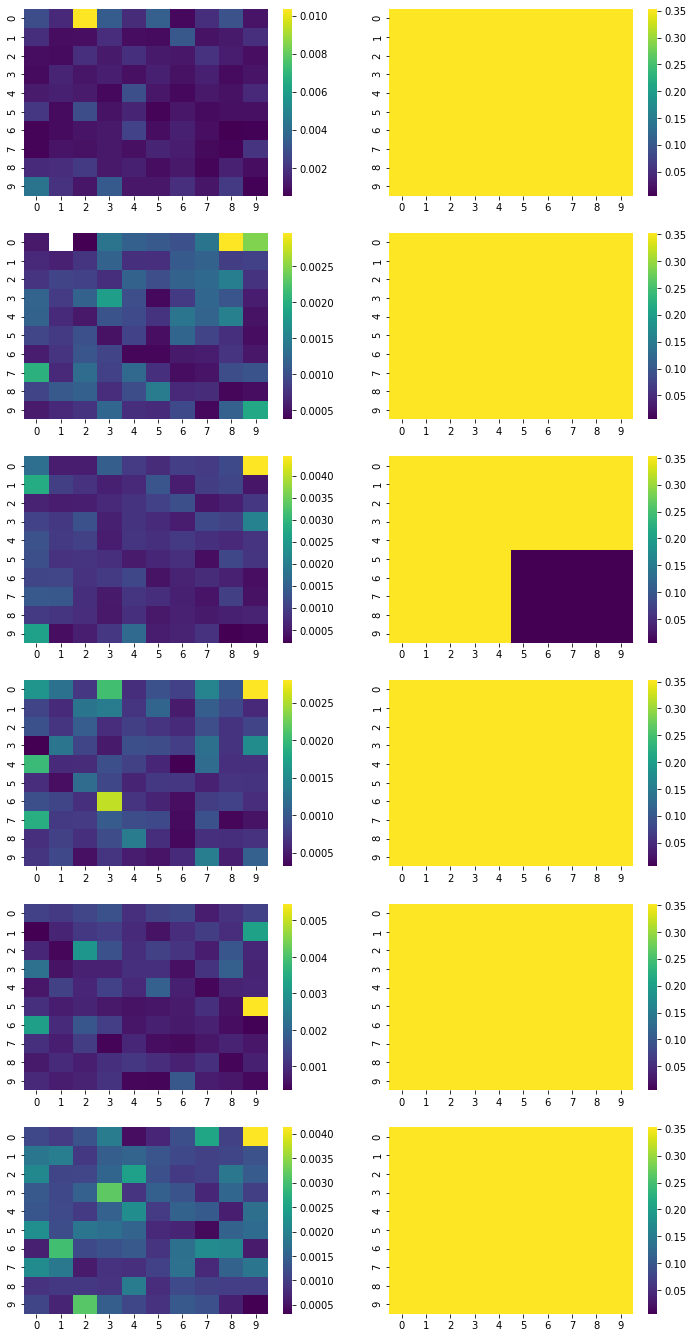

In [76]:
n = len(volume.get_passives())
fig,axs = plt.subplots(n,2, figsize=(12,24))
true = volume.get_rad_cube()

pred.min()

for i in range(n):
    sns.heatmap(pred[i].data.cpu().numpy(),ax=axs[i][0], cmap='viridis')
    sns.heatmap(true[i].data.cpu().numpy(),ax=axs[i][1], cmap='viridis', vmin=true.min(), vmax=true.max())    

In [62]:
sb.location.shape

torch.Size([8439, 3])